In [571]:
using PyPlot, LightGraphs
srand(1)
t = [ones(10,10) * 0 ones(10,10); ones(20,10) ones(20,10)] * 2;
y = t + randn(30,20);

In [543]:
# a function for BSGM_cartesian (Section 5.2.)

# y       : a matrix of data
# init    : initialization of y

function BSGM_kronecker_biclust(y;
                                ind1 = 1:size(y,1), ind2 = 1:size(y,2),
                                init = y,
                                v0 = 1e-1,
                                convtol = 1e-14,  
                                iter = 10)
                            
    
    # get size
    n1, n2 = size(y); n = n1 * n2;
    k1 = length(ind1); k2 = length(ind2);
    p1 = n1 * k1; p2 = n2 * k2;
    
    # initialize
    theta = copy(y);
    mu = y[ind1,ind2];
    temp = (repeat(theta, outer = [k1, k2]) - repeat(mu, inner = [n1, n2])).^2;
    q1 = reshape(exp.(-sum(temp/k2,2)/(2*n2*v0)),n1,k1); q1 = q1./sum(q1,2);
    q2 = reshape(exp.(-sum(temp/k1,1)[:]/(2*n1*v0)),n2,k2); q2 = q2./sum(q2,2);
    sigmasq = 1;
    
    # loop start
    for i = 1:iter
        
        # save previous iteration
        q1_old = copy(q1);
        q2_old = copy(q2);
        
        # E-step: update g1, g2
        temp = (repeat(theta, outer = [k1, k2]) - repeat(mu, inner = [n1, n2])).^2;
        q1 = reshape(exp.(-sum(q2[:]' .* temp,2)/(2*n2*v0)),n1,k1); q1 = q1./sum(q1,2);
        q2 = reshape(exp.(-sum(q1[:] .* temp,1)[:]/(2*n1*v0)),n2,k2); q2 = q2./sum(q2,2);
        
        # M-step: update theta
        L1 = (speye(n1) - (q1 ./ sum(q1,1)) * q1')/v0;
        L2 = (speye(n2) - (q2 ./ sum(q2,1)) * q2')/v0;
        L = kron(L2,L1); L = (L + abs.(L))/2; L = Diagonal(sum(L,2)[:]) - L;
        theta = reshape((speye(n) + L)\y[:], n1, n2);
        
        # M-step: update mu
        mu = (q1 ./ sum(q1,1))' * theta * (q2 ./ sum(q2,1));
        
        if rem(i,5) == 0
            @printf "%2d-th iteration done: error = %0.2e\n" i norm(q1 - q1_old) + norm(q2 - q2_old)
        end
        
        if norm(q1 - q1_old) + norm(q2 - q2_old) < convtol
            @printf "the algorithm converged at %2d-th iteration: error = %0.2e\n" i norm(q1 - q1_old) + norm(q2 - q2_old)
            break;
        end
        
    end
    
    return Dict([
                (:theta, theta), (:q1, q1), (:q2, q2), (:mu, mu), (:final, q1*mu*q2')
                ])
end

BSGM_kronecker_biclust (generic function with 1 method)

In [572]:
out = BSGM_kronecker_biclust(y, v0 = 1e-1/25, iter = 1000);

 5-th iteration done: error = 8.48e-14
the algorithm converged at  6-th iteration: error = 8.34e-99


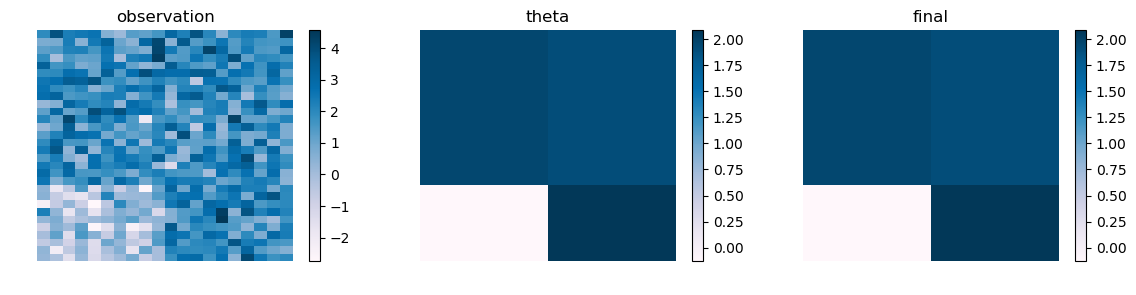

In [573]:
fig, ax = subplots(1,2, figsize = (14,3))
subplot(131); pcolormesh(y, cmap = "PuBu"); axis("off"); title("observation"); colorbar();
subplot(132); pcolormesh(out[:theta], cmap = "PuBu"); axis("off"); title("theta"); colorbar();
subplot(133); pcolormesh(out[:final], cmap = "PuBu"); axis("off"); title("final"); colorbar();